<a href="https://colab.research.google.com/github/KDT-GrabIT/Animal-Image-Retrieval/blob/main/Animal_Image_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
files.upload() # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download theaayushbajaj/cbir-dataset

Dataset URL: https://www.kaggle.com/datasets/theaayushbajaj/cbir-dataset
License(s): unknown
 69% 159M/232M [00:00<00:00, 1.66GB/s]
100% 232M/232M [00:00<00:00, 1.66GB/s]


In [4]:
!unzip -q cbir-dataset.zip

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
data_dir = '/content/dataset' # 환경에 따라 경로가 다를 수 있음
image_paths = glob.glob(os.path.join(data_dir, "*.jpg")) # 하위 폴더 내 모든 jpg

print(f"총 이미지 개수: {len(image_paths)}")


총 이미지 개수: 4738


In [7]:
class AnimalDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, path

In [8]:
# 전처리 정의
trn_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(512, 512), antialias=True), # Kaggle 기준 수치
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = AnimalDataset(image_paths, transform=trn_transforms)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            # (3, 512, 512) -> (16, 171, 171)
            nn.Conv2d(3, 16, kernel_size=3, stride=3, padding=1),
            nn.GELU(),
            nn.MaxPool2d(2, stride=2), # (16, 85, 85)
            # (16, 85, 85) -> (8, 43, 43)
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            nn.MaxPool2d(2, stride=1), # (8, 42, 42)
            nn.Flatten(),
            nn.Linear(8 * 42 * 42, latent_dim)
        )
    def forward(self, x):
        return self.net(x)

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # 인코더의 Flatten 크기와 일치하도록 설정 (8 * 42 * 42)
        self.linear = nn.Sequential(nn.Linear(latent_dim, 8 * 42 * 42), nn.ReLU())

        self.net = nn.Sequential(
            # (8, 42, 42) -> (16, 85, 85)
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(),

            # (16, 85, 85) -> (8, 255, 255)
            # output_padding=1을 제거하여 256이 아닌 255로 맞춤
            nn.ConvTranspose2d(16, 8, kernel_size=5, stride=3, padding=1),
            nn.ReLU(),

            # (8, 255, 255) -> (3, 512, 512)
            nn.ConvTranspose2d(8, 3, kernel_size=6, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], 8, 42, 42)
        return self.net(x)

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    def forward(self, x):
        latent = self.encoder(x)
        return latent, self.decoder(latent)

In [12]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def train_model(model, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for inputs, _ in tqdm(loader):
            inputs = inputs.to(device)
            optimizer.zero_grad()
            _, outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {train_loss/len(loader):.4f}")

In [14]:
train_model(model, loader, epochs=5)

100%|██████████| 297/297 [00:26<00:00, 11.15it/s]


Epoch 1, Loss: 0.1310


100%|██████████| 297/297 [00:25<00:00, 11.82it/s]


Epoch 2, Loss: 0.0880


100%|██████████| 297/297 [00:25<00:00, 11.82it/s]


Epoch 3, Loss: 0.0765


100%|██████████| 297/297 [00:25<00:00, 11.83it/s]


Epoch 4, Loss: 0.0697


100%|██████████| 297/297 [00:25<00:00, 11.77it/s]

Epoch 5, Loss: 0.0648


In [15]:
def get_embed(model, data_loader):
    image_list, embed_list, path_list = [], [], []
    model.eval()
    with torch.no_grad():
        for inputs, paths in tqdm(data_loader):
            inputs = inputs.to(device)
            latents = model.encoder(inputs)
            image_list.append(inputs.cpu())
            embed_list.append(latents.cpu())
            path_list.extend(paths)
    return torch.cat(image_list, dim=0), torch.cat(embed_list, dim=0), path_list

In [16]:
all_images, all_embeds, all_paths = get_embed(model, loader)

100%|██████████| 297/297 [00:31<00:00,  9.30it/s]


In [17]:
def imshow(inputs, title):
    inputs = 0.5 * inputs + 0.5
    grid = utils.make_grid(inputs, padding=2, normalize=True)
    plt.figure(figsize=(15, 7))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show()

In [18]:
def find_similar_images(query_idx, all_images, all_embeds, k=5):
    query_embed = all_embeds[query_idx]
    # 파일의 torch.cdist 방식 적용
    dist = torch.cdist(query_embed[None, :], all_embeds, p=2).squeeze(0)

    # 본인 포함 가장 가까운 k+1개 추출
    _, topk_indices = torch.topk(dist, k + 1, largest=False)
    topk_images = all_images[topk_indices]

    imshow(topk_images, f'Query Animal (Left) and Top-{k} Matches')

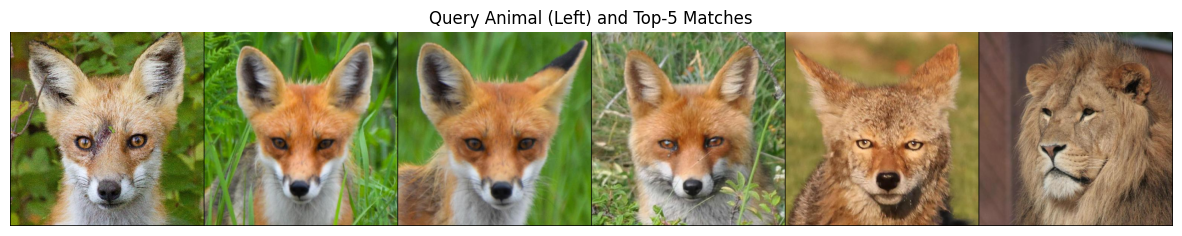

In [19]:
find_similar_images(query_idx=0, all_images=all_images, all_embeds=all_embeds)